# Part-of-Speech Tagging using Recurrent Neural Networks (RNN and LSTM)
Author: Pierre Nugues

A part-of-speech tagger using recurrent networks and GloVe embeddings and trained on a corpus following the Universal Dependencies format. Here we use the English Web Treebank:
https://github.com/UniversalDependencies/UD_English-EWT/tree/master.

## Python Headers

### The Modules

In [1]:
import sys
import os
import time
import math
import random
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, initializers
from tensorflow.keras.layers import LSTM, Bidirectional, SimpleRNN, Dense, Embedding
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

2022-09-22 12:22:33.149779: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Some Parameters

In [2]:
OPTIMIZER = 'rmsprop'
BATCH_SIZE = 128
EPOCHS = 10
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 150
LSTM_UNITS = 512
MINI_CORPUS = False

In [3]:
random.seed(1234)
np.random.seed(1234)
tf.keras.utils.set_random_seed(1234)

## Preprocessing

### Loading the Embeddings
We will use GloVe embeddings and load them

In [4]:
def load(file):
    """
    Return the embeddings in the from of a dictionary
    :param file:
    :return:
    """
    file = file
    embeddings = {}
    glove = open(file)
    for line in glove:
        values = line.strip().split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        embeddings[word] = vector
    glove.close()
    embeddings_dict = embeddings
    embedded_words = sorted(list(embeddings_dict.keys()))
    return embeddings_dict

In [5]:
embedding_file = '/Users/pierre/Documents/Cours/EDAN20/corpus/glove.6B.100d.txt'
embeddings_dict = load(embedding_file)

In [6]:
embeddings_dict['table']

array([-0.61454  ,  0.89693  ,  0.56771  ,  0.39102  , -0.22437  ,
        0.49035  ,  0.10868  ,  0.27411  , -0.23833  , -0.52153  ,
        0.73551  , -0.32654  ,  0.51304  ,  0.32415  , -0.46709  ,
        0.68051  , -0.25497  , -0.040484 , -0.54418  , -1.0548   ,
       -0.46692  ,  0.23557  ,  0.31234  , -0.34537  ,  0.14793  ,
       -0.53745  , -0.43215  , -0.48724  , -0.51019  , -0.9051   ,
       -0.17919  , -0.018376 ,  0.09719  , -0.31623  ,  0.7512   ,
        0.92236  , -0.49965  ,  0.14036  , -0.28296  , -0.97443  ,
       -0.0094408, -0.62944  ,  0.14711  , -0.94376  ,  0.0075222,
        0.18565  , -0.99172  ,  0.072789 , -0.18474  , -0.52901  ,
        0.38995  , -0.45677  , -0.21932  ,  1.3723   , -0.29636  ,
       -2.2342   , -0.36667  ,  0.04987  ,  0.63421  ,  0.53275  ,
       -0.53955  ,  0.31398  , -0.44698  , -0.38389  ,  0.066668 ,
       -0.02168  ,  0.20558  ,  0.59456  , -0.24892  , -0.52795  ,
       -0.3761   ,  0.077104 ,  0.75222  , -0.2647   , -0.0587

### Loading the Corpus

In [7]:
def load_ud_en_ewt():
    BASE_DIR = '/Users/pierre/Documents/Cours/EDAN20/corpus/ud-treebanks-v2.9/UD_English-EWT/'
    train_file = BASE_DIR + 'en_ewt-ud-train.conllu'
    dev_file = BASE_DIR + 'en_ewt-ud-dev.conllu'
    test_file = BASE_DIR + 'en_ewt-ud-test.conllu'
    column_names = ['ID', 'FORM', 'LEMMA', 'UPOS', 'XPOS', 
                    'FEATS', 'HEAD', 'DEPREL', 'HEAD', 'DEPS', 'MISC']
    column_names = list(map(str.lower, column_names))
    train_sentences = open(train_file).read().strip()
    dev_sentences = open(dev_file).read().strip()
    test_sentences = open(test_file).read().strip()
    # test2_sentences = open(test2_file).read().strip()
    return train_sentences, dev_sentences, test_sentences, column_names

def load_conll2009_pos():
    BASE_DIR = '/Users/pierre/Documents/Cours/EDAN20/corpus/conll2009/en/'
    train_file = BASE_DIR + 'CoNLL2009-ST-English-train-pos.txt'
    dev_file = BASE_DIR + 'CoNLL2009-ST-English-development-pos.txt'
    test_file = BASE_DIR + 'CoNLL2009-ST-test-words-pos.txt'
    # test2_file = 'simple_pos_test.txt'

    column_names = ['id', 'form', 'lemma', 'plemma', 'pos', 'ppos']

    train_sentences = open(train_file).read().strip()
    dev_sentences = open(dev_file).read().strip()
    test_sentences = open(test_file).read().strip()
    # test2_sentences = open(test2_file).read().strip()
    return train_sentences, dev_sentences, test_sentences, column_names

# train_sentences, dev_sentences, test_sentences, column_names = \
# load_conll2009_pos()
train_sentences, dev_sentences, test_sentences, column_names =\
load_ud_en_ewt()
train_sentences[:100]

'# newdoc id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000\n# sent_id = weblog-jua'

### Converting the Corpus in a Dictionary
We follow the fit-transform pattern of sklearn

In [8]:
import regex as re

class Token(dict):
    pass

class CoNLLDictorizer:

    def __init__(self, column_names, sent_sep='\n\n', col_sep=' +'):
        self.column_names = column_names
        self.sent_sep = sent_sep
        self.col_sep = col_sep

    def fit(self):
        pass

    def transform(self, corpus):
        corpus = corpus.strip()
        sentences = re.split(self.sent_sep, corpus)
        return list(map(self._split_in_words, sentences))

    def fit_transform(self, corpus):
        return self.transform(corpus)

    def _split_in_words(self, sentence):
        rows = re.split('\n', sentence)
        rows = [row for row in rows if row[0] != '#']
        return [Token(dict(zip(self.column_names,
                               re.split(self.col_sep, row))))
                for row in rows]

In [9]:
conll_dict = CoNLLDictorizer(column_names, col_sep='\t')

train_dict = conll_dict.transform(train_sentences)
dev_dict = conll_dict.transform(dev_sentences)
test_dict = conll_dict.transform(test_sentences)

if MINI_CORPUS:
    train_dict = train_dict[:len(train_dict) // 5]
print('First sentence, train:', train_dict[0])

First sentence, train: [{'id': '1', 'form': 'Al', 'lemma': 'Al', 'upos': 'PROPN', 'xpos': 'NNP', 'feats': 'Number=Sing', 'head': '0:root', 'deprel': 'root', 'deps': 'SpaceAfter=No'}, {'id': '2', 'form': '-', 'lemma': '-', 'upos': 'PUNCT', 'xpos': 'HYPH', 'feats': '_', 'head': '1:punct', 'deprel': 'punct', 'deps': 'SpaceAfter=No'}, {'id': '3', 'form': 'Zaman', 'lemma': 'Zaman', 'upos': 'PROPN', 'xpos': 'NNP', 'feats': 'Number=Sing', 'head': '1:flat', 'deprel': 'flat', 'deps': '_'}, {'id': '4', 'form': ':', 'lemma': ':', 'upos': 'PUNCT', 'xpos': ':', 'feats': '_', 'head': '1:punct', 'deprel': 'punct', 'deps': '_'}, {'id': '5', 'form': 'American', 'lemma': 'American', 'upos': 'ADJ', 'xpos': 'JJ', 'feats': 'Degree=Pos', 'head': '6:amod', 'deprel': 'amod', 'deps': '_'}, {'id': '6', 'form': 'forces', 'lemma': 'force', 'upos': 'NOUN', 'xpos': 'NNS', 'feats': 'Number=Plur', 'head': '7:nsubj', 'deprel': 'nsubj', 'deps': '_'}, {'id': '7', 'form': 'killed', 'lemma': 'kill', 'upos': 'VERB', 'xpos'

### Function to build the two-way sequences
Two vectors: $\mathbf{x}$ and $\mathbf{y}$

In [10]:
def build_sequences(corpus_dict, key_x='form', key_y='upos', tolower=True):
    """
    Creates sequences from a list of dictionaries
    :param corpus_dict:
    :param key_x:
    :param key_y:
    :return:
    """
    X = []
    Y = []
    for sentence in corpus_dict:
        x = []
        y = []
        for word in sentence:
            x += [word[key_x]]
            y += [word[key_y]]
        if tolower:
            x = list(map(str.lower, x))
        X += [x]
        Y += [y]
    return X, Y

In [11]:
X_train_cat, Y_train_cat = build_sequences(train_dict)
X_val_cat, Y_val_cat = build_sequences(dev_dict)
print('First sentence, words', X_train_cat[0])
print('First sentence, POS', Y_train_cat[0])

First sentence, words ['al', '-', 'zaman', ':', 'american', 'forces', 'killed', 'shaikh', 'abdullah', 'al', '-', 'ani', ',', 'the', 'preacher', 'at', 'the', 'mosque', 'in', 'the', 'town', 'of', 'qaim', ',', 'near', 'the', 'syrian', 'border', '.']
First sentence, POS ['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT']


### Extracting the Unique Words and Parts of Speech

In [12]:
vocabulary_words = sorted(list(
    set([word for sentence 
         in X_train_cat for word in sentence])))
pos = sorted(list(set([pos for sentence 
                       in Y_train_cat for pos in sentence])))
print(pos)
NB_CLASSES = len(pos)

['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', '_']


### We create the dictionary
We add two words for the padding symbol and unknown words

In [13]:
embeddings_words = embeddings_dict.keys()
print('Words in GloVe:',  len(embeddings_dict.keys()))
vocabulary_words = sorted(list(set(vocabulary_words + 
                                   list(embeddings_words))))
cnt_uniq = len(vocabulary_words) + 2
print('# unique words in the vocabulary: embeddings and corpus:', 
      cnt_uniq)

Words in GloVe: 400000
# unique words in the vocabulary: embeddings and corpus: 402011


### Function to convert the words or parts of speech to indices

In [14]:
def to_index(X, idx):
    """
    Convert the word lists (or POS lists) to indexes
    :param X: List of word (or POS) lists
    :param idx: word to number dictionary
    :return:
    """
    X_idx = []
    for x in X:
        # We map the unknown words to one
        x_idx = list(map(lambda x: idx.get(x, 1), x))
        X_idx += [x_idx]
    return X_idx

### We create the indexes

In [15]:
# We start at one to make provision for the padding symbol 0 
# in RNN and LSTMs and 1 for the unknown words
idx_word = dict(enumerate(vocabulary_words, start=2))
idx_pos = dict(enumerate(pos, start=1))
word_idx = {v: k for k, v in idx_word.items()}
pos_idx = {v: k for k, v in idx_pos.items()}
print('word index:', list(word_idx.items())[:10])
print('POS index:', list(pos_idx.items())[:10])

word index: [('!', 2), ('!!', 3), ('!!!', 4), ('!!!!', 5), ('!!!!!', 6), ('!!!!!!', 7), ('!!!!!!!', 8), ('!!!!!!!!!!', 9), ('!!!!!!!!!!!', 10), ('!!!!!!!!!!!!', 11)]
POS index: [('ADJ', 1), ('ADP', 2), ('ADV', 3), ('AUX', 4), ('CCONJ', 5), ('DET', 6), ('INTJ', 7), ('NOUN', 8), ('NUM', 9), ('PART', 10)]


In [16]:
# We create the parallel sequences of indexes
X_train_idx = to_index(X_train_cat, word_idx)
Y_train_idx = to_index(Y_train_cat, pos_idx)

X_val_idx = to_index(X_val_cat, word_idx)
Y_val_idx = to_index(Y_val_cat, pos_idx)

print('First sentences, word indices', X_train_idx[:3])
print('First sentences, POS indices', Y_train_idx[:3])

First sentences, word indices [[50470, 655, 397776, 43353, 54057, 152357, 208704, 328597, 44671, 50470, 655, 56044, 491, 359087, 292649, 62657, 359087, 251780, 189667, 359087, 364968, 269521, 298022, 491, 259602, 359087, 352115, 81542, 925], [43477, 359991, 208727, 269521, 43521, 308150, 103362, 389638, 71696, 94742, 375911, 367780, 152285, 395327, 362757, 106352, 925, 43479], [129560, 43353, 193786, 64120, 56459, 359030, 359635, 171707, 88398, 375205, 22156, 358190, 95699, 272103, 189667, 66894, 925]]
First sentences, POS indices [[12, 13, 12, 13, 1, 8, 16, 12, 12, 12, 13, 12, 13, 6, 8, 2, 6, 8, 2, 6, 8, 2, 12, 13, 2, 6, 1, 8, 13], [13, 6, 8, 2, 6, 1, 8, 4, 4, 16, 11, 8, 2, 8, 10, 16, 13, 13], [12, 13, 1, 8, 16, 14, 11, 4, 16, 2, 9, 1, 8, 16, 2, 12, 13]]


### We pad the sentences

In [17]:
X_train = pad_sequences(X_train_idx, padding='post')
Y_train = pad_sequences(Y_train_idx, padding='post')

X_val = pad_sequences(X_val_idx, padding='post')
Y_val = pad_sequences(Y_val_idx, padding='post')

In [18]:
X_train[0]

array([ 50470,    655, 397776,  43353,  54057, 152357, 208704, 328597,
        44671,  50470,    655,  56044,    491, 359087, 292649,  62657,
       359087, 251780, 189667, 359087, 364968, 269521, 298022,    491,
       259602, 359087, 352115,  81542,    925,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [19]:
Y_train[0]

array([12, 13, 12, 13,  1,  8, 16, 12, 12, 12, 13, 12, 13,  6,  8,  2,  6,
        8,  2,  6,  8,  2, 12, 13,  2,  6,  1,  8, 13,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [20]:
# The number of POS classes and 0 (padding symbol)
Y_train_vectorized = to_categorical(Y_train, num_classes=len(pos) + 1)
Y_val_vectorized = to_categorical(Y_val, num_classes=len(pos) + 1)
Y_train_vectorized[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### We create an embedding matrix
0 is the padding symbol and index one is a unknown word

In [21]:
rdstate = np.random.RandomState(1234567)
embedding_matrix = rdstate.uniform(-0.05, 0.05, 
                                   (len(vocabulary_words) + 2, 
                                    EMBEDDING_DIM))

In [22]:
for word in vocabulary_words:
    if word in embeddings_dict:
        # If the words are in the embeddings, we fill them with a value
        embedding_matrix[word_idx[word]] = embeddings_dict[word]

In [23]:
embedding_matrix.shape

(402011, 100)

Embedding of table

In [24]:
embedding_matrix[word_idx['table']]

array([-0.61453998,  0.89692998,  0.56770998,  0.39102   , -0.22437   ,
        0.49035001,  0.10868   ,  0.27410999, -0.23833001, -0.52152997,
        0.73550999, -0.32653999,  0.51304001,  0.32415   , -0.46709001,
        0.68050998, -0.25497001, -0.040484  , -0.54417998, -1.05480003,
       -0.46691999,  0.23557   ,  0.31233999, -0.34536999,  0.14793   ,
       -0.53745002, -0.43215001, -0.48723999, -0.51019001, -0.90509999,
       -0.17918999, -0.018376  ,  0.09719   , -0.31623   ,  0.75120002,
        0.92236   , -0.49965   ,  0.14036   , -0.28296   , -0.97443002,
       -0.0094408 , -0.62944001,  0.14711   , -0.94375998,  0.0075222 ,
        0.18565001, -0.99172002,  0.072789  , -0.18474001, -0.52901   ,
        0.38995001, -0.45677   , -0.21932   ,  1.37230003, -0.29635999,
       -2.2342    , -0.36667001,  0.04987   ,  0.63420999,  0.53275001,
       -0.53955001,  0.31398001, -0.44698   , -0.38389   ,  0.066668  ,
       -0.02168   ,  0.20558   ,  0.59456003, -0.24891999, -0.52

Embedding of the padding symbol, idx 0, random numbers

In [25]:
embedding_matrix[0]

array([-0.02629708, -0.04923516, -0.04801697, -0.01869074, -0.04005453,
       -0.03048257, -0.0292702 , -0.03350688,  0.0211879 , -0.04679333,
       -0.03026304,  0.0464557 ,  0.00738946,  0.01992277,  0.04746414,
        0.01543505, -0.02391317, -0.03035904,  0.03614633, -0.01292743,
       -0.01311645,  0.00429138,  0.01827985,  0.03228761, -0.03686076,
       -0.04223968,  0.03409078, -0.0278994 ,  0.02529113, -0.0156977 ,
       -0.04902496, -0.01042922, -0.029072  , -0.00319148, -0.01353996,
        0.00950514,  0.0413734 , -0.00028032, -0.01519774, -0.01369095,
        0.03702888, -0.01152137,  0.03035301,  0.00264644, -0.0463597 ,
       -0.02356203, -0.033484  , -0.02621933, -0.03773337,  0.01826283,
        0.03646911, -0.04109766, -0.03953006,  0.04822013, -0.02821295,
       -0.0431476 , -0.02476419,  0.04927545, -0.02866612, -0.00881531,
       -0.01183301,  0.02965345, -0.03483367,  0.0109977 , -0.04514807,
       -0.0231921 ,  0.00176915,  0.00485835, -0.0040727 , -0.01

## The Network

In [26]:
model = models.Sequential([
    Embedding(len(vocabulary_words) + 2,
              EMBEDDING_DIM,
              mask_zero=True,
              embeddings_initializer=initializers.Constant(embedding_matrix),
              trainable=True,
              input_length=None),
    # SimpleRNN(128, return_sequences=True),
    # Bidirectional(SimpleRNN(128, return_sequences=True)),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dense(NB_CLASSES + 1, activation='softmax')])

# The default is True
#model.layers[0].trainable = True

2022-09-22 12:22:52.496923: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### We fit it

In [27]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         40201100  
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        234496    
 l)                                                              
                                                                 
 dense (Dense)               (None, None, 19)          4883      
                                                                 
Total params: 40,440,479
Trainable params: 40,440,479
Non-trainable params: 0
_________________________________________________________________


We use a callback to store our best model using the validation loss

In [29]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('simple_lstm.keras',
                                   save_best_only=True)
]

In [30]:
history = model.fit(X_train, Y_train_vectorized, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data=(X_val, Y_val_vectorized), 
                    batch_size=BATCH_SIZE)

Epoch 1/10
98/98 [==============================] - 210s 2s/step - loss: 0.1217 - accuracy: 0.6764 - val_loss: 0.0955 - val_accuracy: 0.8386
Epoch 2/10
98/98 [==============================] - 244s 2s/step - loss: 0.0380 - accuracy: 0.8943 - val_loss: 0.0579 - val_accuracy: 0.8970
Epoch 3/10
98/98 [==============================] - 236s 2s/step - loss: 0.0250 - accuracy: 0.9278 - val_loss: 0.0469 - val_accuracy: 0.9164
Epoch 4/10
98/98 [==============================] - 204s 2s/step - loss: 0.0198 - accuracy: 0.9422 - val_loss: 0.0422 - val_accuracy: 0.9239
Epoch 5/10
98/98 [==============================] - 193s 2s/step - loss: 0.0166 - accuracy: 0.9514 - val_loss: 0.0394 - val_accuracy: 0.9287
Epoch 6/10
98/98 [==============================] - 195s 2s/step - loss: 0.0143 - accuracy: 0.9581 - val_loss: 0.0386 - val_accuracy: 0.9301
Epoch 7/10
98/98 [==============================] - 201s 2s/step - loss: 0.0126 - accuracy: 0.9632 - val_loss: 0.0371 - val_accuracy: 0.9321
Epoch 8/10
98

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

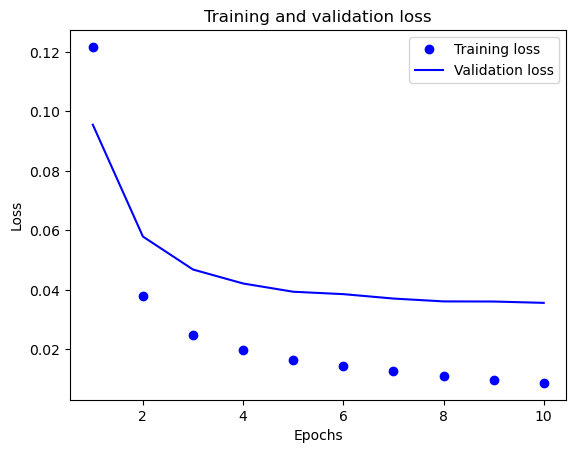

In [32]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

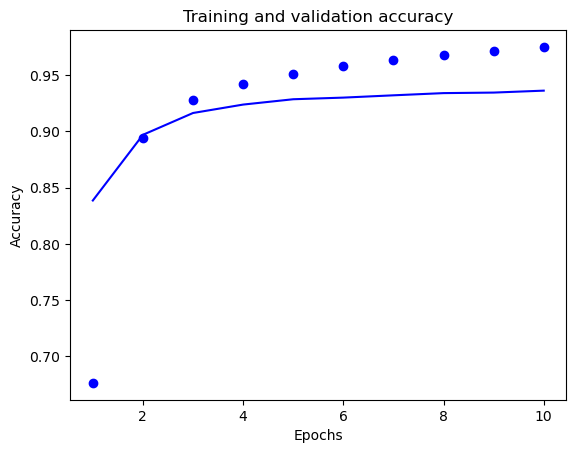

In [33]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

We load our best model

In [34]:
model = load_model('simple_lstm.keras')

## Evaluation

### Formatting the Test Set

In [35]:
# In X_dict, we replace the words with their index
X_test_cat, Y_test_cat = build_sequences(test_dict)
# We create the parallel sequences of indexes
X_test_idx = to_index(X_test_cat, word_idx)
Y_test_idx = to_index(Y_test_cat, pos_idx)

print('X[0] test idx', X_test_idx[0])
print('Y[0] test idx', Y_test_idx[0])

X_test_padded = pad_sequences(X_test_idx, padding='post')
Y_test_padded = pad_sequences(Y_test_idx, padding='post')
print('X[0] test idx passed', X_test_padded[0])
print('Y[0] test idx padded', Y_test_padded[0])
# One extra symbol for 0 (padding)
Y_test_padded_vectorized = to_categorical(Y_test_padded, 
                                          num_classes=len(pos) + 1)
print('Y[0] test idx padded vectorized', Y_test_padded_vectorized[0])
print(X_test_padded.shape)
print(Y_test_padded_vectorized.shape)

X[0] test idx [388238, 187828, 165435, 251417, 193007, 1, 43465]
Y[0] test idx [11, 14, 12, 16, 2, 12, 13]
X[0] test idx passed [388238 187828 165435 251417 193007      1  43465      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0]
Y[0] test idx padded [11 14 12 16  2 12 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0 

### Evaluation

In [36]:
# Evaluates with the padding symbol
test_loss, test_acc = model.evaluate(X_test_padded, 
                                     Y_test_padded_vectorized)
print('Loss:', test_loss)
print('Accuracy:', test_acc)

65/65 [==============================] - 11s 106ms/step - loss: 0.0293 - accuracy: 0.9393
Loss: 0.029303688555955887
Accuracy: 0.9393463134765625


We reach 93.50 with bidirectional LSTMs

### We evaluate on all the test corpus

X_test

In [37]:
X_test_cat[0]

['what', 'if', 'google', 'morphed', 'into', 'googleos', '?']

X_test_padded

In [38]:
X_test_padded[0]

array([388238, 187828, 165435, 251417, 193007,      1,  43465,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0], dtype=int32)

In [39]:
Y_test_probs_padded = model.predict(X_test_padded)

65/65 [==============================] - 12s 105ms/step


Y_test

In [40]:
Y_test_cat[0]

['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'PROPN', 'PUNCT']

Y_test_padded

In [41]:
Y_test_padded[0]

array([11, 14, 12, 16,  2, 12, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

Y_test_probs

In [42]:
Y_test_probs_padded[0]

array([[4.2179745e-06, 3.4063582e-05, 1.5962181e-06, ..., 6.9175335e-04,
        1.5393369e-06, 3.9493654e-05],
       [1.8363790e-08, 9.5742178e-07, 7.7434917e-05, ..., 3.2422601e-04,
        2.5507468e-06, 2.1174039e-06],
       [2.7261723e-10, 2.7451824e-07, 9.0425686e-07, ..., 1.6519092e-03,
        6.5697626e-05, 1.8230659e-06],
       ...,
       [2.8488036e-02, 5.4061148e-02, 5.1971558e-02, ..., 5.4056689e-02,
        7.7951521e-02, 4.4408318e-02],
       [2.8488036e-02, 5.4061148e-02, 5.1971558e-02, ..., 5.4056689e-02,
        7.7951521e-02, 4.4408318e-02],
       [2.8488036e-02, 5.4061148e-02, 5.1971558e-02, ..., 5.4056689e-02,
        7.7951521e-02, 4.4408318e-02]], dtype=float32)

Y_test_hat

In [43]:
list(map(np.argmax, Y_test_probs_padded[0]))

[11,
 14,
 12,
 16,
 2,
 8,
 13,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17]

### Remove padding

In [44]:
Y_test_probs = []
for sent_nbr, y_test_probs_padded in enumerate(Y_test_probs_padded):
    Y_test_probs += [y_test_probs_padded[:len(X_test_cat[sent_nbr])]]
print(Y_test_probs[:1])

[array([[4.21797449e-06, 3.40635816e-05, 1.59621811e-06, 1.74035272e-03,
        1.44881608e-06, 7.07458503e-06, 3.36544053e-03, 8.24801158e-04,
        7.39410025e-05, 3.08276640e-07, 1.81541491e-05, 9.90415335e-01,
        5.66283688e-06, 1.02879198e-06, 2.77373218e-03, 2.85358848e-08,
        6.91753346e-04, 1.53933695e-06, 3.94936542e-05],
       [1.83637905e-08, 9.57421776e-07, 7.74349173e-05, 9.30924216e-06,
        2.00123191e-04, 1.69591221e-05, 7.34085625e-05, 6.69848487e-06,
        5.22338887e-05, 5.54126345e-09, 2.73840925e-07, 5.94707763e-06,
        4.04611492e-05, 2.16564658e-05, 9.99165177e-01, 4.57605950e-07,
        3.24226014e-04, 2.55074679e-06, 2.11740394e-06],
       [2.72617234e-10, 2.74518243e-07, 9.04256865e-07, 3.42305902e-05,
        2.27311961e-04, 1.14704756e-06, 3.70243725e-07, 5.88148112e-07,
        1.02013967e-03, 2.35954744e-07, 1.77206985e-05, 5.52210622e-05,
        9.96694922e-01, 3.54765518e-07, 2.12576924e-04, 1.46394796e-05,
        1.65190920e-0

### Convert POS indices to symbols

In [45]:
Y_test_cat_hat = []
for y_probs in Y_test_probs:
    y_idx = list(map(np.argmax, y_probs))
    y_cat_hat = list(map(idx_pos.get, y_idx))
    Y_test_cat_hat += [y_cat_hat]

print(Y_test_cat_hat[:2])
print(Y_test_cat[:2])

[['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'NOUN', 'PUNCT'], ['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'PRON', 'NOUN', 'PUNCT', 'NOUN', 'PUNCT', 'CCONJ', 'ADV', 'NOUN', 'PUNCT', 'VERB', 'ADP', 'DET', 'ADJ', 'PUNCT', 'ADJ', 'NOUN', 'NOUN', 'PUNCT']]
[['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'PROPN', 'PUNCT'], ['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'PRON', 'NOUN', 'PUNCT', 'NOUN', 'PUNCT', 'CCONJ', 'ADV', 'NOUN', 'PUNCT', 'NOUN', 'ADP', 'DET', 'ADV', 'PUNCT', 'ADJ', 'NOUN', 'NOUN', 'PUNCT']]


### Evaluate

In [46]:
total, correct, total_ukn, correct_ukn = 0, 0, 0, 0
for id_s, x_test_cat in enumerate(X_test_cat):
    for id_w, word in enumerate(x_test_cat):
        total += 1
        if Y_test_cat_hat[id_s][id_w] == Y_test_cat[id_s][id_w]:
            correct += 1
        # The word is not in the dictionary
        if word not in word_idx:
            total_ukn += 1
            if Y_test_cat_hat[id_s][id_w] == Y_test_cat[id_s][id_w]:
                correct_ukn += 1

print('total %d, correct %d, accuracy %f' % 
      (total, correct, correct / total))
if total_ukn != 0:
    print('total unknown %d, correct %d, accuracy %f' % 
          (total_ukn, correct_ukn, correct_ukn / total_ukn))

total 25456, correct 23912, accuracy 0.939346
total unknown 489, correct 307, accuracy 0.627812


## Prediction of parts of speech

In [47]:
def predict_sentence(sentence, model, word_idx, 
                     vocabulary_words, idx_pos, verbose=False):
    # Predict one sentence
    sentence = sentence.split()
    word_idxs = to_index([sentence], word_idx)
    pos_idx_pred = model.predict(word_idxs)[0]
    pos_idxs = list(map(np.argmax, pos_idx_pred))
    pos = list(map(idx_pos.get, pos_idxs))
    if verbose:
        print('Sentence', sentence)
        print('Sentence word indexes', word_idxs)
        #print('Padded sentence', word_idx_padded)
        print('POS predicted', pos_idx_pred[0])
        print('POS shape', pos_idx_pred.shape)
    return pos

In [48]:
sentences = ['That round table might collapse .',
                 'The man can learn well .',
                 'The man can swim .',
                 'The man can simwo .']
for sentence in sentences:
    y_test_cat_hat = predict_sentence(sentence.lower(), 
                                       model, word_idx, 
                                       vocabulary_words, 
                                       idx_pos)
    print(sentence)
    print(y_test_cat_hat)

1/1 [==============================] - 3s 3s/step
That round table might collapse .
['PRON', 'ADJ', 'NOUN', 'AUX', 'VERB', 'PUNCT']
1/1 [==============================] - 0s 73ms/step
The man can learn well .
['DET', 'NOUN', 'AUX', 'VERB', 'ADV', 'PUNCT']
1/1 [==============================] - 4s 4s/step
The man can swim .
['DET', 'NOUN', 'AUX', 'VERB', 'PUNCT']
1/1 [==============================] - 0s 50ms/step
The man can simwo .
['DET', 'NOUN', 'AUX', 'VERB', 'PUNCT']
